## Concept Primer
What this method is for, when to use it, and key assumptions.

## Config Guide
| Parameter | Why it matters | Recommended starting point |
|---|---|---|
| `task.type` | Chooses learning objective | Match your prediction problem |
| `split.n_splits` | Controls CV variance/bias tradeoff | 4-5 for most tabular tasks |
| `train.metrics` | Governs optimization visibility | Include one primary + one robustness metric |

## Result Interpretation
Read metrics together with plots; avoid single-metric decisions.

## If-Then Sensitivity
Try one parameter change and compare outcome direction before broad tuning.

## Common Pitfalls
Watch for leakage, unstable splits, and train/test drift before model selection.

## Further Reading
- README notebook section
- `DESIGN_BLUEPRINT.md` 13.4
- API reference under `veldra.api`

# Lalonde DR-DiD Analysis Workflow with Veldra

This notebook demonstrates a scenario-driven **DR-DiD** analysis on Lalonde data.
Business question: what is the ATT of training (`treat=1`) on earnings growth from `re75` to `re78`?


## Prerequisites and Caveats

- First run downloads data from a public URL; reruns use local cache.
- DR-DiD assumptions still matter (especially parallel trends and overlap).
- This notebook uses `design="panel"` with one pre and one post period per unit.


In [1]:
import json
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from veldra.api import estimate_dr


def _resolve_repo_root(start: Path) -> Path:
    current = start.resolve()
    for base in [current, *current.parents]:
        if (base / "pyproject.toml").exists() and (base / "examples").exists():
            return base
    return start.resolve()


ROOT = _resolve_repo_root(Path.cwd())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

OUT_DIR = ROOT / "examples" / "out" / "notebook_lalonde_drdid"
OUT_DIR.mkdir(parents=True, exist_ok=True)

CACHE_PATH = OUT_DIR / "lalonde_raw.parquet"
PANEL_PATH = OUT_DIR / "lalonde_panel.parquet"
SUMMARY_PATH = OUT_DIR / "lalonde_drdid_summary.json"

LALONDE_URL = "https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/MatchIt/lalonde.csv"
TREATMENT_COL = "treat"
PRE_OUTCOME_COL = "re75"
POST_OUTCOME_COL = "re78"
TARGET_COL = "outcome"

BASE_FEATURES = ["age", "educ", "black", "hispan", "married", "nodegree", "re74"]
REQUIRED_COLUMNS = [TREATMENT_COL, PRE_OUTCOME_COL, POST_OUTCOME_COL, *BASE_FEATURES]


C:\home\VeldraML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
FALLBACK_CACHE_PATHS = [
    CACHE_PATH,
    ROOT / "examples" / "out" / "notebook_lalonde_dr" / "lalonde_raw.parquet",
]

lalonde_df = None
cache_mode = None
for candidate in FALLBACK_CACHE_PATHS:
    if candidate.exists():
        lalonde_df = pd.read_parquet(candidate)
        cache_mode = f"cache:{candidate.name}"
        break

if lalonde_df is None:
    try:
        raw_df = pd.read_csv(LALONDE_URL)
        lalonde_df = _normalize_lalonde(raw_df)
        lalonde_df.to_parquet(CACHE_PATH, index=False)
        cache_mode = "url"
    except Exception as exc:  # pragma: no cover - notebook runtime fallback
        raise RuntimeError(
            "Failed to load Lalonde data from URL and no local cache was found. "
            f"Expected cache at: {[str(p) for p in FALLBACK_CACHE_PATHS]}"
        ) from exc

print(f"cache_mode={cache_mode}")
print(f"cache_path={CACHE_PATH}")
display(lalonde_df.head())


cache_mode=cache:lalonde_raw.parquet
cache_path=C:\home\VeldraML\examples\out\notebook_lalonde_drdid\lalonde_raw.parquet


,treat,re78,age,educ,black,hispan,married,nodegree,re74,re75
0,1,9930.0460,37,11,1,0,1,1,0.0,0.0
1,1,3595.8940,22,9,0,1,0,1,0.0,0.0
2,1,24909.4500,30,12,1,0,0,0,0.0,0.0
3,1,7506.1460,27,11,1,0,0,1,0.0,0.0
4,1,289.7899,33,8,1,0,0,1,0.0,0.0


In [3]:
missing = [col for col in REQUIRED_COLUMNS if col not in lalonde_df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

panel_pre = lalonde_df[[TREATMENT_COL, PRE_OUTCOME_COL, *BASE_FEATURES]].copy()
panel_pre["time"] = 0
panel_pre["post"] = 0
panel_pre[TARGET_COL] = panel_pre[PRE_OUTCOME_COL].astype(float)

panel_post = lalonde_df[[TREATMENT_COL, POST_OUTCOME_COL, *BASE_FEATURES]].copy()
panel_post["time"] = 1
panel_post["post"] = 1
panel_post[TARGET_COL] = panel_post[POST_OUTCOME_COL].astype(float)

panel_pre["unit_id"] = np.arange(len(panel_pre), dtype=int)
panel_post["unit_id"] = np.arange(len(panel_post), dtype=int)

panel_pre = panel_pre.drop(columns=[PRE_OUTCOME_COL])
panel_post = panel_post.drop(columns=[POST_OUTCOME_COL])
panel_df = pd.concat([panel_pre, panel_post], ignore_index=True)
panel_df.to_parquet(PANEL_PATH, index=False)

print(f"panel_path={PANEL_PATH}")
display(panel_df.head())


panel_path=C:\home\VeldraML\examples\out\notebook_lalonde_drdid\lalonde_panel.parquet


,treat,age,educ,black,hispan,married,nodegree,re74,time,post,outcome,unit_id
0,1,37,11,1,0,1,1,0.0,0,0,0.0,0
1,1,22,9,0,1,0,1,0.0,0,0,0.0,1
2,1,30,12,1,0,0,0,0.0,0,0,0.0,2
3,1,27,11,1,0,0,1,0.0,0,0,0.0,3
4,1,33,8,1,0,0,1,0.0,0,0,0.0,4


In [4]:
print("n_rows:", len(panel_df))
print("n_units:", panel_df["unit_id"].nunique())
print("treated_units:", int(panel_df.loc[panel_df["post"] == 0, TREATMENT_COL].sum()))

summary = panel_df.groupby(["post", TREATMENT_COL])[TARGET_COL].agg(["count", "mean", "std"])
display(summary)


n_rows: 1228
n_units: 614
treated_units: 185


count         mean          std
post treat                                 
0    0        429  2466.484443  3291.996183
     1        185  1532.055314  3219.250870
1    0        429  6984.169742  7294.161791
     1        185  6349.143530  7867.402218

In [5]:
config = {
    "config_version": 1,
    "task": {"type": "regression"},
    "data": {
        "path": str(PANEL_PATH),
        "target": TARGET_COL,
        "id_cols": [],
        "drop_cols": [],
    },
    "split": {"type": "kfold", "n_splits": 5, "seed": 42},
"train": {
        "seed": 42,
        "num_boost_round": 2000,
        "early_stopping_rounds": 200,
        "early_stopping_validation_fraction": 0.2,
        "auto_num_leaves": True,
        "num_leaves_ratio": 1.0,
        "min_data_in_leaf_ratio": 0.01,
        "min_data_in_bin_ratio": 0.01,
        "metrics": ["rmse", "mae"],
        "lgb_params": {
            "learning_rate": 0.01,
            "max_bin": 255,
            "max_depth": 10,
            "feature_fraction": 1.0,
            "bagging_fraction": 1.0,
            "bagging_freq": 0,
            "lambda_l1": 0.0,
            "lambda_l2": 0.000001,
            "min_child_samples": 20,
            "first_metric_only": True,
        },
    },
    "causal": {
        "method": "dr_did",
        "design": "panel",
        "treatment_col": TREATMENT_COL,
        "time_col": "time",
        "post_col": "post",
        "unit_id_col": "unit_id",
        "estimand": "att",
        "propensity_calibration": "platt",
        "propensity_clip": 0.01,
        "cross_fit": True,
    },
    "export": {"artifact_dir": "artifacts"},
}

result = estimate_dr(config)
print("run_id:", result.run_id)
print("estimate:", result.estimate)
print("95% CI:", result.ci_lower, result.ci_upper)
display(pd.DataFrame([result.metrics]))


C:\home\VeldraML\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 指定されたファイルが見つかりません。
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\home\VeldraML\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\home\VeldraML\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\home\VeldraML\.uv_python\cpython-3.11.14-windows-x86_64-none\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

run_id: b8ce5361e7ff45ecbf239b03ee91f452
estimate: 5331.629044810575
95% CI: 3995.930108325208 6667.327981295941


,naive,ipw,dr,treated_rate,coverage_treated,overlap_metric,drdid
0,299.402917,4631.038247,5331.629045,0.301303,0.959727,0.0,5331.629045


In [6]:
summary_path = Path(result.metadata["summary_path"])
obs_path = Path(result.metadata["observation_path"])

summary_payload = json.loads(summary_path.read_text(encoding="utf-8"))
obs = pd.read_parquet(obs_path)

estimate_table = pd.DataFrame([
    {"metric": "naive", "value": result.metrics.get("naive")},
    {"metric": "ipw", "value": result.metrics.get("ipw")},
    {"metric": "dr", "value": result.metrics.get("dr")},
    {"metric": "drdid", "value": result.metrics.get("drdid")},
    {"metric": "ci_lower", "value": result.ci_lower},
    {"metric": "ci_upper", "value": result.ci_upper},
])

display(estimate_table)
display(obs.head())
print("overlap_metric:", summary_payload.get("overlap_metric", result.metrics.get("overlap_metric")))


,metric,value
0,naive,299.402917
1,ipw,4631.038247
2,dr,5331.629045
3,drdid,5331.629045
4,ci_lower,3995.930108
5,ci_upper,6667.327981


,treatment,outcome,e_raw,e_hat,m1_hat,m0_hat,psi,weight,unit_id,y_pre,y_post,y_diff
0,1,9930.0460,0.999629,0.962043,11838.711284,-1397.777335,37596.127177,3.318919,0,0.0,9930.0460,9930.0460
1,1,3595.8940,0.999571,0.962028,6463.860947,1813.336536,5916.163691,3.318919,1,0.0,3595.8940,3595.8940
2,1,24909.4500,0.999620,0.962041,10260.428997,-506.320837,84352.882671,3.318919,2,0.0,24909.4500,24909.4500
3,1,7506.1460,0.999626,0.962043,9756.285859,-901.609558,27904.658988,3.318919,3,0.0,7506.1460,7506.1460
4,1,289.7899,0.999626,0.962042,8076.335118,1217.914812,-3080.371329,3.318919,4,0.0,289.7899,289.7899


overlap_metric: 0.0


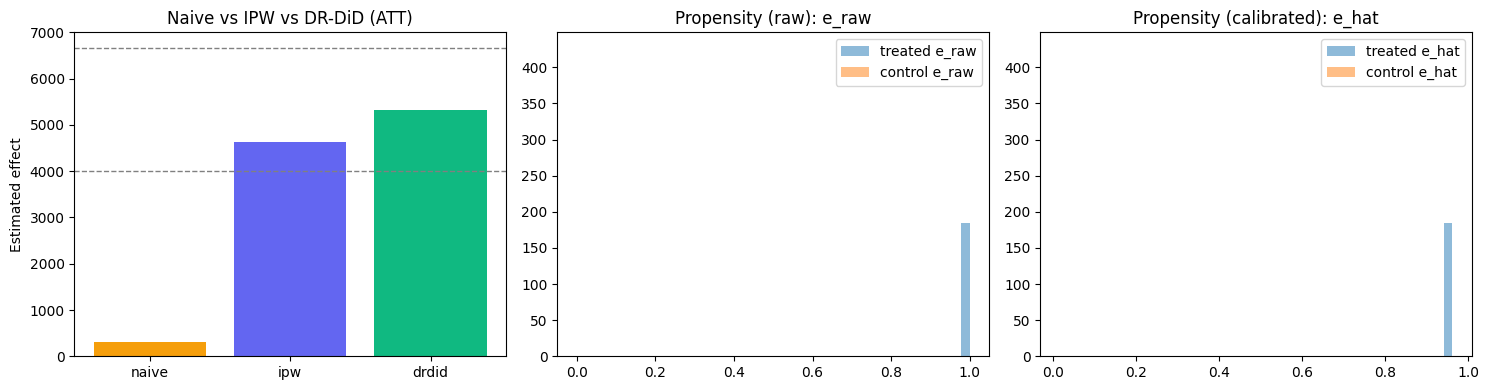

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plot_df = estimate_table[estimate_table["metric"].isin(["naive", "ipw", "drdid"])].copy()
axes[0].bar(plot_df["metric"], plot_df["value"], color=["#f59e0b", "#6366f1", "#10b981"])
axes[0].axhline(result.ci_lower, color="gray", linestyle="--", linewidth=1)
axes[0].axhline(result.ci_upper, color="gray", linestyle="--", linewidth=1)
axes[0].set_title("Naive vs IPW vs DR-DiD (ATT)")
axes[0].set_ylabel("Estimated effect")

for tval, label in [(1, "treated"), (0, "control")]:
    mask = obs["treatment"] == tval
    axes[1].hist(obs.loc[mask, "e_raw"], bins=20, alpha=0.5, label=f"{label} e_raw")
    axes[2].hist(obs.loc[mask, "e_hat"], bins=20, alpha=0.5, label=f"{label} e_hat")

axes[1].set_title("Propensity (raw): e_raw")
axes[2].set_title("Propensity (calibrated): e_hat")
axes[1].legend()
axes[2].legend()
plt.tight_layout()
plt.show()


,feature,smd_unweighted,smd_weighted
2,black,1.670826,0.0
4,married,-0.720755,0.0
6,re74,-0.596761,0.0
3,hispan,-0.277398,0.0
0,age,-0.242300,0.0
5,nodegree,0.235491,0.0
1,educ,0.044830,0.0


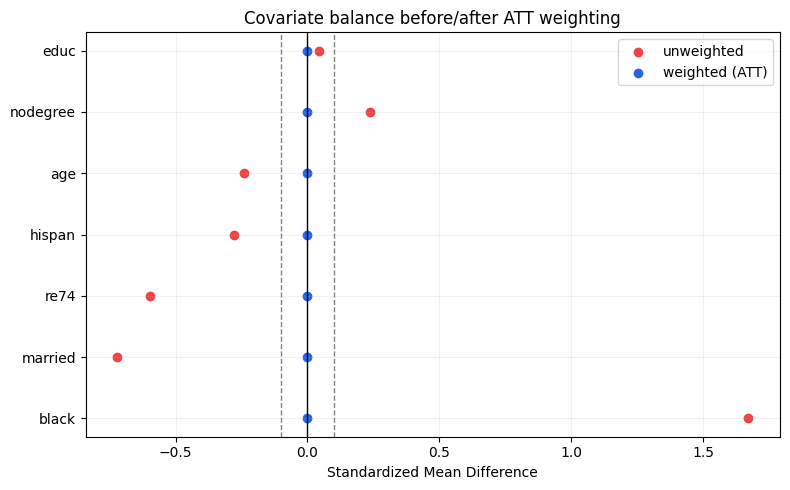

In [8]:
def _weighted_mean(x: np.ndarray, w: np.ndarray) -> float:
    denom = float(np.sum(w))
    if denom <= 0:
        return float("nan")
    return float(np.sum(x * w) / denom)

def _weighted_var(x: np.ndarray, w: np.ndarray) -> float:
    mu = _weighted_mean(x, w)
    if np.isnan(mu):
        return float("nan")
    denom = float(np.sum(w))
    if denom <= 0:
        return float("nan")
    return float(np.sum(w * (x - mu) ** 2) / denom)

def _smd(x_t: np.ndarray, x_c: np.ndarray) -> float:
    denom = np.sqrt((np.var(x_t) + np.var(x_c)) / 2.0)
    return float((np.mean(x_t) - np.mean(x_c)) / denom) if denom > 0 else 0.0

def _smd_weighted(x_t: np.ndarray, w_t: np.ndarray, x_c: np.ndarray, w_c: np.ndarray) -> float:
    mu_t = _weighted_mean(x_t, w_t)
    mu_c = _weighted_mean(x_c, w_c)
    var_t = _weighted_var(x_t, w_t)
    var_c = _weighted_var(x_c, w_c)
    denom = np.sqrt((var_t + var_c) / 2.0)
    if denom <= 0 or np.isnan(denom):
        return 0.0
    return float((mu_t - mu_c) / denom)

base_df = panel_df.loc[panel_df["post"] == 0, ["unit_id", TREATMENT_COL, *BASE_FEATURES]].copy()
weights = obs[["unit_id", "weight"]].copy()
balance_src = base_df.merge(weights, on="unit_id", how="inner")

records = []
for col in BASE_FEATURES:
    t_mask = balance_src[TREATMENT_COL] == 1
    c_mask = balance_src[TREATMENT_COL] == 0
    x_t = balance_src.loc[t_mask, col].to_numpy(dtype=float)
    x_c = balance_src.loc[c_mask, col].to_numpy(dtype=float)
    w_t = balance_src.loc[t_mask, "weight"].to_numpy(dtype=float)
    w_c = balance_src.loc[c_mask, "weight"].to_numpy(dtype=float)
    records.append(
        {
            "feature": col,
            "smd_unweighted": _smd(x_t, x_c),
            "smd_weighted": _smd_weighted(x_t, w_t, x_c, w_c),
        }
    )

balance_df = pd.DataFrame(records).sort_values(
    "smd_unweighted",
    key=lambda s: np.abs(s),
    ascending=False,
)
display(balance_df)

fig, ax = plt.subplots(figsize=(8, 5))
y = np.arange(len(balance_df))
ax.scatter(balance_df["smd_unweighted"], y, label="unweighted", color="#ef4444")
ax.scatter(balance_df["smd_weighted"], y, label="weighted (ATT)", color="#2563eb")
ax.axvline(0.0, color="black", linewidth=1)
ax.axvline(0.1, color="gray", linestyle="--", linewidth=1)
ax.axvline(-0.1, color="gray", linestyle="--", linewidth=1)
ax.set_yticks(y)
ax.set_yticklabels(balance_df["feature"])
ax.set_xlabel("Standardized Mean Difference")
ax.set_title("Covariate balance before/after ATT weighting")
ax.legend()
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [9]:
analysis_summary = {
    "run_id": result.run_id,
    "method": result.method,
    "estimand": result.estimand,
    "estimate": result.estimate,
    "ci_lower": result.ci_lower,
    "ci_upper": result.ci_upper,
    "metrics": result.metrics,
    "metadata": result.metadata,
    "overlap_metric": summary_payload.get("overlap_metric", result.metrics.get("overlap_metric")),
}
SUMMARY_PATH.write_text(json.dumps(analysis_summary, indent=2, sort_keys=True), encoding="utf-8")
print(f"summary_path={SUMMARY_PATH}")


summary_path=C:\home\VeldraML\examples\out\notebook_lalonde_drdid\lalonde_drdid_summary.json


## Interpretation Notes

- `drdid` is the primary ATT estimate in this notebook.
- Compare Naive/IPW/DR-DiD to understand confounding and weighting impact.
- Inspect overlap and SMD diagnostics before using the estimate operationally.
- This is a 2-period panel MVP demonstration; multi-period DiD is out of scope.
